---

# Week - 4 Filling the corrupt Frames | SoC 2025 - AnimAI Project 
We are stepping towards our final project from now on, this notebook processes the Human3.6M dataset to analyze 2D keypoint trajectories, perform cubic spline interpolation for missing frames, apply Gaussian smoothing, and generate visualizations including static plots, animations, and videos. The code clones the VideoPose3D repository, downloads the MoCap dataset Human3.6M, and creates side-by-side comparisons of ground truth and reconstructed keypoint trajectories.

## Objectives
- Extract and visualize 2D keypoints for a specific subject and action.
- Reconstruct missing keypoints using cubic spline interpolation.
- Smooth trajectories using Gaussian filtering.
- Generate videos comparing ground truth, reconstructed, and known-only keypoint sequences.

## Prerequisites
- VS Code environment with GPU/CPU support.
- Internet access for cloning repositories and downloading datasets.
- Familiarity with Python, NumPy, Matplotlib, and OpenCV.

Usage of auxiliary modules such as `os`,`subprocess` and `urllib` has been done in this notebook, with explanations provided alongside their usage in the relevant code sections. Don't be intimated by them, they will help us in creating a smooth workflow, with minimal interaction with terminal, file explorer etc, for example playing a video in VS Code itself is difficult, so we have to again and again open file explorer to play the output videos, instead this help us play directly while we run the code snippet. 

**Suggestion:** Keep note of the type and shape of certain variables, especially which variables involing `numpy`, this will make it much easier to follow the workflow and debug issues.

## Setup and Data extraction

Cloning the VideoPose3D repository and downloading the Human3.6M 2D keypoint dataset `data_2d_h36m_cpn_ft_h36m_dbb.npz`

In [1]:
import os # os is a popular module that provides a way of using operating system dependent functionality like reading or writing to the file system.
import urllib.request # this module can be used for opening and reading URLs.
import subprocess  # subprocess is a module that allows you to start and manage new processes, like say playing a video or running a command in the terminal.

# This script checks if the VideoPose3D repository exists locally on your PC, clones it if not,
# it downloads our dataset called Human3.6M if it is not already present.

if not os.path.exists("VideoPose3D"):
    subprocess.run(["git", "clone", "https://github.com/facebookresearch/VideoPose3D.git"])

# Download dataset if not exists
data_path = "VideoPose3D/data/data_2d_h36m_cpn_ft_h36m_dbb.npz"
os.makedirs(os.path.dirname(data_path), exist_ok=True)

if not os.path.exists(data_path):
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/video-pose-3d/data_2d_h36m_cpn_ft_h36m_dbb.npz",
        data_path
    )
    print("Dataset downloaded.")
else:
    print("Dataset already exists. You can start using it directly.")


Dataset already exists. You can start using it directly.


### Importing Data by the path

In [3]:
import numpy as np

# Load dataset
data = np.load(data_path, allow_pickle=True) # allow_pickle=True allows loading of objects stored in the file, such as dictionaries or lists. 
print(data.files)  # List all available files in the dataset

['positions_2d', 'metadata']


#### Inspecting `metadata` dictionary

In [5]:
metadata = data['metadata'].item()
print(type(metadata))
print(metadata.keys())

<class 'dict'>
dict_keys(['layout_name', 'num_joints', 'keypoints_symmetry'])


In [7]:
print(metadata['layout_name'])          # dataset name
print(metadata['num_joints'])           # number of nodes stored in the dataset   
print(metadata['keypoints_symmetry'])   # symmetry of the keypoints these are the keypoints 
# keypoints on leftside of the body are mirrored to the right side, i.e 4 and 1 are mirrored to each other, can observe this soon

h36m
17
[[4, 5, 6, 11, 12, 13], [1, 2, 3, 14, 15, 16]]


#### Inspecting `Positions` dictionary

In [9]:
positions = data['positions_2d'].item()

print(type(positions))  # type of positions is a dictionary
print(len(positions))   # number of subjects in the dataset
print("Subjects:", list(positions.keys()))             # number of people's motion in the dataset
print("Actions for S2:", list(positions['S2'].keys())) # Inspect actions for subject S2(one person)
print("Shape of S2 - Walking 1 - Cam 0:", positions['S2']['Walking 1'][0].shape) # Inspect shape of keypoints for a specific action and camera

<class 'dict'>
10
Subjects: ['S6', 'S7', 'S5', 'S11', 'S1', 'S9', 'S8', 'S2', 'S3', 'S4']
Actions for S2: ['Directions 1', 'Discussion 1', 'Eating 1', 'Greeting 1', 'Phoning 1', 'Posing 1', 'Purchases 1', 'Sitting 1', 'SittingDown 2', 'Smoking 1', 'Photo 1', 'Waiting 1', 'Walking 1', 'WalkDog 1', 'WalkTogether 1', 'Directions', 'Discussion', 'Eating 2', 'Greeting', 'Phoning', 'Posing', 'Purchases', 'Sitting', 'SittingDown 3', 'Smoking', 'Photo', 'Waiting', 'Walking', 'WalkDog', 'WalkTogether']
Shape of S2 - Walking 1 - Cam 0: (3236, 17, 2)



This can be interpreted as:

- **3236 frames** — The number of frames in the video sequence (i.e., time steps).
- **17 joints** — Each frame contains 17 keypoints representing human body joints (according to the Human3.6M format).
- **2 coordinates** — Each joint is represented by 2 values: **(x, y)** position in the 2D image plane.

Our dataset contains motion sequences captured with **4 simultaneous cameras** at different positions and angles.

Originally, we found this dataset in the GitHub repository: [facebookresearch/VideoPose3D](https://github.com/facebookresearch/VideoPose3D).

It is quite interesting, 2D to 3D pose estimation! You can check that out too if you are intrested.

Visualising the first frame in a specific motion sequence

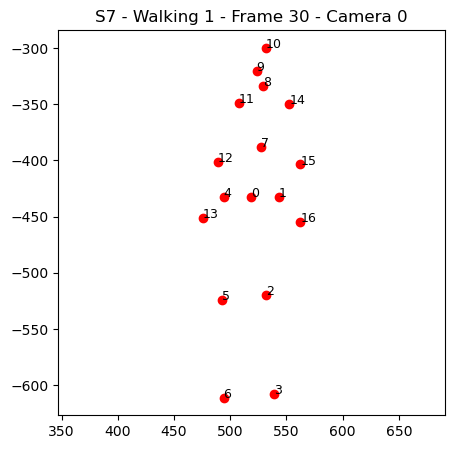

Shape of keypoints for all frames: (3637, 17, 2)
Shape of keypoints in single frame: (17, 2)
[[518.44446 432.85156]
 [542.8889  432.85156]
 [531.8889  519.5677 ]
 [539.2222  607.5052 ]
 [494.      432.85156]
 [492.77777 524.4531 ]
 [494.      611.16925]
 [527.      387.66147]
 [529.44446 333.92188]
 [523.3333  320.48697]
 [531.8889  299.72397]
 [507.44446 348.57812]
 [489.1111  401.09634]
 [475.66666 451.17188]
 [552.6667  349.79947]
 [562.44446 403.53906]
 [562.44446 454.83594]]


In [15]:
import matplotlib.pyplot as plt

subject = 'S7' # Subject S7 is one of the subjects in the dataset, can change to any other subject like S1, S2, etc.
action = 'Walking 1' # Action 'Walking 1' is one of the actions performed by the subject, can change to any other action like 'Eating', 'Smoking', etc.

keypoints_all = positions[subject][action][0]  # Camera view 0 (4 cameras available: 0,1,2,3)
# keypoints_all is a numpy array of shape (n_frames, 17, 2) where n_frames is the number of frames in the video, 17 is the number of joints, and 2 represents x and y coordinates of each joint.

keypoints = keypoints_all[30]  # 30th frame
#keypoints is a numpy array of shape (17, 2) where 17 is the number of joints and 2 represents x and y coordinates of each joint.

plt.figure(figsize=(5, 5))
plt.scatter(keypoints[:, 0], -keypoints[:, 1], c='r') # here we have to negate the y-coordinates because in the video, y-coordinates are inverted (y increases downwards)

for i in range(keypoints.shape[0]): # just to label the keypoints
    x, y = keypoints[i]
    plt.text(x, -y, str(i), fontsize=9)

plt.title(f"{subject} - {action} - Frame 30 - Camera 0")
plt.axis('equal')
plt.show()

print("Shape of keypoints for all frames:", keypoints_all.shape)  # Shape of all frames (n_frames, 17, 2)
print("Shape of keypoints in single frame:", keypoints.shape)  # Shape of keypoints (17, 2) - 17 joints, each with x and y coordinates
print(keypoints)  # Printing keypoints for the first frame

For better visualisation, instead of just nodes (key points), we often use stick diagrams (skeleton edges) :

In [17]:
# defining skeleton edges for Human3.6M Dataset (for line connections)
skeleton_edges = [
    (0, 1),   # Hip -> Right Hip
    (1, 2),   # Right Hip -> Right Knee
    (2, 3),   # Right Knee -> Right Ankle
    (0, 4),   # Hip -> Left Hip
    (4, 5),   # Left Hip -> Left Knee
    (5, 6),   # Left Knee -> Left Ankle
    (0, 7),   # Hip -> Spine
    (7, 8),   # Spine -> Thorax
    (8, 9),   # Thorax -> Neck
    (9, 10),  # Neck -> Head

    (8, 11),  # Thorax -> Left Shoulder
    (11, 12), # Left Shoulder -> Left Elbow
    (12, 13), # Left Elbow -> Left Wrist

    (8, 14),  # Thorax -> Right Shoulder
    (14, 15), # Right Shoulder -> Right Elbow
    (15, 16)  # Right Elbow -> Right Wrist
]
print(len(skeleton_edges))  # type of skeleton_edges is a list

16


#### Plotting the Stick Diagram

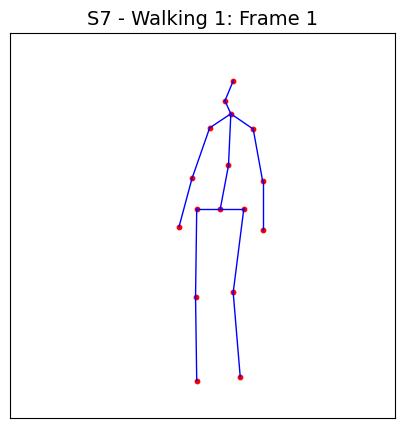

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(keypoints[:, 0], -keypoints[:, 1], c='r', s=10)

# Drawing skeleton
for i, j in skeleton_edges:
    x = [keypoints[i, 0], keypoints[j, 0]]
    y = [-keypoints[i, 1], -keypoints[j, 1]]
    plt.plot(x, y, 'b', linewidth=1)

# Axes styling
plt.xticks([]) # just to remove x-ticks
plt.yticks([])
plt.xlim(300, 700)
plt.ylim(-650, -250)
plt.gca().set_aspect('equal') #this sets the aspect ratio of the plot to be equal, so that the x and y axes are scaled equally.
plt.title(f"{subject} - {action}: Frame {1}", fontsize=14)
plt.grid(False)
plt.show()


The code below is used to draw and save frames with skeletons for each keypoint in the dataset.

**Again, keep in mind that:**  
- Each `keypoints_all` array contains all frames for a specific subject and action, from a particular camera view:
    ```python
    keypoints_all = positions[subject][action][0]  # Camera view 0 (4 cameras available)
    ```
- To access the keypoints for a single frame:
    ```python
    keypoints = keypoints_all[0]  # 1st frame
    ```
    So `keypoints` is a list which contains the node position in a single specific frame
    
- Here, `subject` specifies which person we want the data for (e.g., `'S7'`), and `action` specifies the activity (e.g., `'Walking 1'`, `'Sitting 1'`, etc.).

A **frame** refers to a single time step in the motion sequence, containing the 2D coordinates for all 17 joints of the subject. The code visualizes these keypoints as skeletons, making it easier to analyze and process human motion data.

In [21]:
#from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2 # cv2 is a library for computer vision tasks, such as image processing and video manipulation.
from tqdm import tqdm # this is used to create a progress bar for loops, can neglect this if you want

width, height = 800, 800  # final video resolution

def draw_skeleton_frame(keypoints, frame_idx=None): 
    fig, ax = plt.subplots(figsize=(6, 6))

    x_margin = 50
    y_margin = 50
    x_min, x_max = keypoints[:, 0].min(), keypoints[:, 0].max()
    y_min, y_max = keypoints[:, 1].min(), keypoints[:, 1].max()

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(-(y_max + y_margin), -(y_min - y_margin))
    ax.set_aspect('equal')
    ax.axis('off')

    ax.scatter(keypoints[:, 0], -keypoints[:, 1], c='blue', s=20) # here s is the size of the points
    for i, j in skeleton_edges:
        x = [keypoints[i, 0], keypoints[j, 0]]
        y = [-keypoints[i, 1], -keypoints[j, 1]]
        ax.plot(x, y, 'b-', lw=2)

    if frame_idx is not None:
        ax.set_title(f"Frame {frame_idx}", fontsize=12)

    fig.tight_layout()
    fig.canvas.draw()
    img = np.asarray(fig.canvas.buffer_rgba()) # Convert the canvas to a numpy array
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR) # Convert RGBA to BGR for OpenCV compatibility, RGBA is a color format used by matplotlib, while OpenCV uses BGR.
    img_bgr = cv2.resize(img_bgr, (width, height))
    plt.close(fig)
    return img_bgr # this returns with skeleton drawn on it


Now we try to visualise frames by cascading them to form a video. The fps of this dataset is 50


In [23]:
# If you want to set video width and height, set them in the above cell itself.
output_path = 'skeleton_video.mp4' # specify your output video path 
fps = 50 # set 'frames per second (fps)' with which you want to play the video, keep it at 50 only as it was shot at 50 fps.
frame_count = 200  # change this to however many frames you want (e.g., 3236 for all)
start_frame = 70 # can change to any starting frame

# ------------ Video writer ------------
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # this line specifies the codec to be used for encoding the video, 'mp4v' is a common codec for MP4 files.
# codec is a program that compresses and decompresses digital video, allowing it to be stored and transmitted efficiently, ignore it for now.
video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
# here type of video is mp4, fps is set to 50, and width and height are set to 800x800 pixels.

# Iterating through frames and drawing skeletons
for f in tqdm(range(start_frame, start_frame + frame_count)): #here tqdm is used to show a progress bar for the loop when we run the script
    keypoints = keypoints_all[f]  # shape: (17, 2) x,y and 17 joints for each frame
    frame_img = draw_skeleton_frame(keypoints, f)
    video.write(frame_img)

video.release()
print("\n" , f"Video saved to: {output_path}")

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.34it/s]


 Video saved to: skeleton_video.mp4


In [25]:
# Now the video will be saved in the same directory as this file is,
# but let's not waste time by again and again going there through file explorer and hit play.
# If we were doing this on a simple py file through terminal, we could've used terminal itself to open the video file,
# but we can make terminal calls through our program itself.

subprocess.run(['start', 'skeleton_video.mp4'], shell=True)  # This line will open the output video, this is for Windows!

# If you are on Linux, you can use:
# subprocess.run(['xdg-open', 'skeleton_video.mp4'], shell=True)

# If you are on Mac, you can use:
# subprocess.run(['open', 'skeleton_video.mp4'], shell=True)

CompletedProcess(args=['start', 'skeleton_video.mp4'], returncode=0)

 If you watch the video, you may see the skeleton "shaking" or jittering, To address this, we apply a 1D Gaussian filter with adjustable variance (sigma) to smooth the keypoint trajectories over time. This reduces high-frequency noise and makes the motion appear more natural and stable. Think about why smoothing in the temporal domain helps reduce visual jitter, it's because it averages out rapid, small fluctuations, preserving the overall motion while suppressing noise.

## Gaussian Filter

The Gaussian filter is a powerful tool for smoothing time-series data, such as 2D keypoint trajectories in motion capture. In this context, the filter is applied **temporally**, i.e. it smooths each joint's (x, y) coordinates across frames, not spatially within a single frame. This helps reduce jitter and noise in the motion sequence, making the movement appear more natural.

### How it works

- For each joint, and for each coordinate (x and y), the filter processes the sequence of values over time (across frames).
- The filter replaces each value with a weighted average of its neighbors, where the weights follow a Gaussian (bell-shaped) curve centered at the current frame.
- The amount of smoothing is controlled by the parameter $\sigma$ (sigma): higher values mean more smoothing.

### Mathematically

Given a time series $x_t$ (e.g., the x-coordinate of a joint at frame $t$), the Gaussian filter computes the smoothed value $\tilde{x}_t$ as:

$$
\tilde{x}_t = \sum_{k=-K}^{K} w_k \, x_{t+k}
$$

where the weights $w_k$ are defined by the Gaussian function:

$$
w_k = \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{k^2}{2\sigma^2}\right)
$$

and the weights are normalized so that $\sum_k w_k = 1$.

- $t$ is the current frame index.
- $k$ ranges over neighboring frames.
- $\sigma$ controls the width of the Gaussian kernel, try tweaking it to see what happens below.

This process is repeated independently for each joint and each coordinate (x and y). This approach is widely used in signal processing and computer vision to enhance the quality of sequential data.

In [27]:
from scipy.ndimage import gaussian_filter1d

def smooth_trajectory(keypoints_2d, sigma=2.0):
    """
    Apply Gaussian smoothing to 2D keypoint trajectories.
    
    Parameters:
        keypoints_2d: np.ndarray
            Array of shape (num_frames, num_joints, 2)
        sigma: float
            Standard deviation for Gaussian filter
    
    Returns:
        smoothed_keypoints: np.ndarray
            Smoothed array of same shape

    """
    smoothed = np.zeros_like(keypoints_2d) #creates an array of zeros with the same shape as keypoints_2d (num_frames, num_joints, 2)

    # Smooth each joint and coordinate separately
    for joint in range(keypoints_2d.shape[1]): #here keypoints_2d.shape[1] gives the number of joints, if it were keypoints_2d.shape[0] it would give the number of frames
        for coord in range(2):  # x and y
            smoothed[:, joint, coord] = gaussian_filter1d(
                keypoints_2d[:, joint, coord],
                sigma=sigma,
                mode='nearest'  # Handles edge effects
            )

    return smoothed

This is the same code now converted to function for accessing it many times!!

In [29]:
def write_skeleton_video(
    keypoints_all,                 # shape: (num_frames, 17, 2)
    draw_skeleton_frame_fn,        # function to draw a single frame, yes you can pass a function as an argument to another function
    output_path,
    fps=50,
    width=640,
    height=480,
    start_frame=0,
    frame_count=200
):
    """
    Saves a video of skeletons given 2D keypoints over time.

    Parameters:
    - keypoints_all: numpy array of shape (num_frames, 17, 2)
    - draw_skeleton_frame_fn: function that takes (keypoints, frame_idx) and returns an image (H, W, 3)
    - output_path: path to save the video
    - fps: frames per second
    - width, height: size of video frames
    - start_frame: index to start from
    - frame_count: number of frames to render
    """
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for f in tqdm(range(start_frame, start_frame + frame_count)):
        keypoints = keypoints_all[f]
        frame_img = draw_skeleton_frame_fn(keypoints, f)
        video.write(frame_img)

    video.release()
    print('\n',f"Video saved to: {output_path}")


Now let's smoothen the previously drawn skeleton video using Gaussian smoothing.

In [31]:
sigma = 3  # Increase for more smoothing but dont go too high or observe it if you want
smoothed_keypoints = smooth_trajectory(keypoints_all, sigma=sigma)
write_skeleton_video(
    smoothed_keypoints,
    draw_skeleton_frame,
    output_path='smoothed_skeleton_video.mp4',
    fps=50,
    width=800,
    height=800,
    start_frame=70,  
    frame_count=200  
)
subprocess.run(['start', 'smoothed_skeleton_video.mp4'], shell=True)  # to open the smoothed video, again this is for Windows, change it according to your OS as mentioned above.

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.04it/s]



 Video saved to: smoothed_skeleton_video.mp4


CompletedProcess(args=['start', 'smoothed_skeleton_video.mp4'], returncode=0)

In [33]:
# Just to compare the original and smoothed videos side by side, we will create a new video that combines both.

vid1 = cv2.VideoCapture('skeleton_video.mp4')
vid2 = cv2.VideoCapture('smoothed_skeleton_video.mp4')

# ------------ Video writer ------------
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('smooth_compare.mp4', fourcc, fps, (width * 2, height))

while True:
    ret1, frame1 = vid1.read()
    ret2, frame2 = vid2.read()
    if not ret1 or not ret2:
        break
    # Stacking frames horizontally
    combined_frame = cv2.hconcat([frame1, frame2])
    out.write(combined_frame)

vid1.release() # It is necessary to release the video capture objects, it will free up a lot of resources cv2 has used.
vid2.release() 
out.release()

subprocess.run(['start', 'smooth_compare.mp4'], shell=True) # again this is for Windows!


CompletedProcess(args=['start', 'smooth_compare.mp4'], returncode=0)

- Notice how the skeleton now moves more smoothly and with less jitter.
- Can you think of a neural network framework that could be trained to remove this type of noise? Feel free to explore resources or references online and don’t worry about whether it can outperform the Gaussian filter, just consider the possibilities!

Moving on, now that we have almost all frames in our dataset sequences, to develop a missing frame filler, we first need a video sequence with some missing frames. We will randomly omit a few frames from our video. These omitted frames will be used later to compare our reconstructed results with the actual ground-truth frames and evaluate the performance of our interpolation methods.

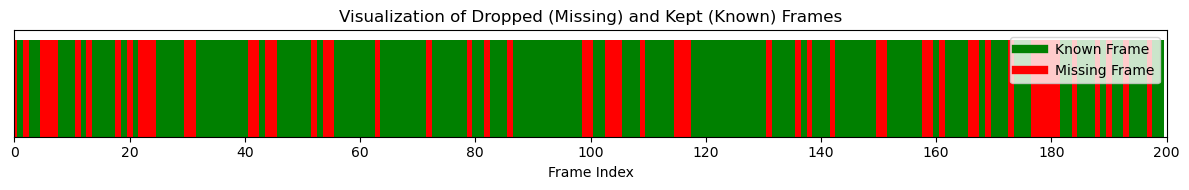

In [35]:
segment_len = 200                  # Total frames
rng = np.random.default_rng(42)
mask = rng.choice([1, 0], size=segment_len, p=[0.7, 0.3])  # 1 = known, 0 = missing 
# Roughly 70% known frames and 30% missing frames

# Plotting bars for known and missing
fig, ax = plt.subplots(figsize=(12, 2))
x = np.arange(segment_len)
for i in range(segment_len):
    color = 'green' if mask[i] == 1 else 'red'
    ax.bar(i, 1, color=color, edgecolor='none', width=1.0)

# Styling
ax.set_xlim(0, segment_len)
ax.set_ylim(0, 1.1)
ax.set_xticks(np.linspace(0, segment_len, 11).astype(int))
ax.set_yticks([])
ax.set_xlabel('Frame Index')
ax.set_title('Visualization of Dropped (Missing) and Kept (Known) Frames')
legend_elements = [
    plt.Line2D([0], [0], color='green', lw=6, label='Known Frame'),
    plt.Line2D([0], [0], color='red', lw=6, label='Missing Frame')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


Here it is harder to visually identify missing and known frames in a long sequence, so I have created a grid structure with rows and columns. In this grid, **green** cells represent known frames and **red** cells represent missing frames. For example, if the 2nd row and 3rd column element is missing, its frame index is `(3-1) + (2-1) × 20 = 22` (since there are 20 columns per row). This visualization makes it easier to spot patterns and locations of missing data in the sequence with numbers printed on the cells.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 21.26it/s]


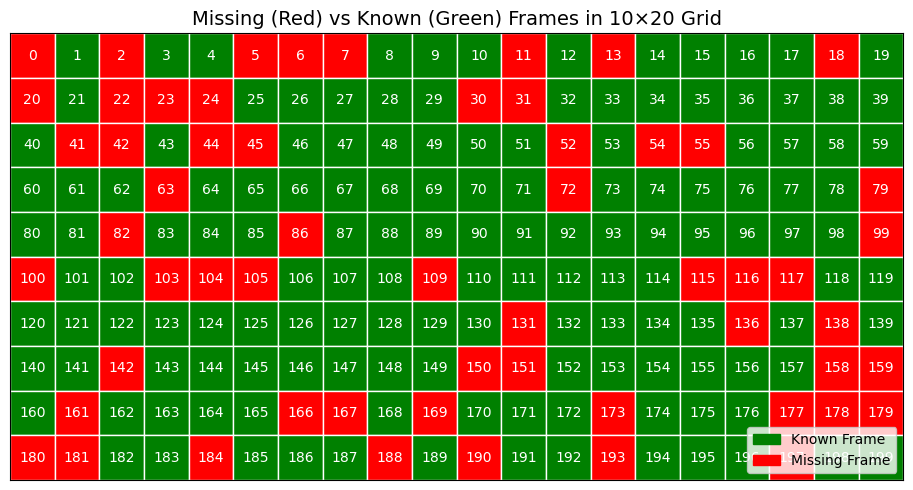

In [37]:

rows, cols = 10, 20
segment_len = rows * cols

fig, ax = plt.subplots(figsize=(10, 5))
cmap = {0: 'red', 1: 'green'}

mask_grid = mask.reshape((rows, cols))

for r in tqdm(range(rows)):
    for c in range(cols):
        color = cmap[mask_grid[r, c]]
        rect = plt.Rectangle((c, rows - 1 - r), 1, 1, facecolor=color, edgecolor='white')
        ax.add_patch(rect)
        # Adding frame number at the center of each cell
        frame_idx = r * cols + c
        ax.text(c + 0.5, rows - 1 - r + 0.5, str(frame_idx), 
                color='white', ha='center', va='center', fontsize=10)

ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Missing (Red) vs Known (Green) Frames in 10×20 Grid", fontsize=14)

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='Known Frame')
red_patch = mpatches.Patch(color='red', label='Missing Frame')
ax.legend(handles=[green_patch, red_patch], loc='lower right')

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


In [39]:
frame_num = 184

print(f"Frame {frame_num} is {'missing' if mask[frame_num] == 0 else 'known'}")


Frame 184 is missing


### Cubic and Linear Spline Interpolation

Cubic and linear spline interpolation are powerful techniques used to construct smooth curves that pass through a given set of data points. Both methods rely on piecewise polynomials, but splines are specifically designed to ensure continuity across intervals—often in terms of value, slope, and curvature.
A clear introduction along with a `scipy` implementation can be found here:
🔗 [Cubic Spline Interpolation – GeeksforGeeks](https://www.geeksforgeeks.org/machine-learning/cubic-spline-interpolation/)

You might loosely relate this to Taylor series, as both involve polynomial approximations. However, Taylor series approximate a function locally using derivatives at a single point, while spline interpolation connects multiple polynomial segments to achieve smoothness across an entire domain. (You can skip this comparison if it's unfamiliar.)

For a more visual and geometric understanding of splines, we highly recommend watching:
🔗 [The Continuity of Splines – Freya Holmér](https://youtu.be/jvPPXbo87ds?si=na12VcpqyAb1UHBt)
Though not all parts are essential, it's an excellent resource for appreciating the mathematical beauty behind spline interpolation.

In [37]:
from scipy.interpolate import interp1d, CubicSpline

joint_idx = 0  # Choose a joint to interpolate, e.g., 0 for the first joint
known_frames = np.where(mask == 1)[0]  # Indices of known frames    
known_keypoints = keypoints_all[known_frames, joint_idx]  # Extracting known keypoints for the joint
#Creating cubic spline interpolator
spline = CubicSpline(known_frames, known_keypoints, axis=0)
# This is for interpolating for all frames

We actually want to predict each missing frame using only its nearby frames, rather than the entire sequence. Using 3–4 neighboring frames for spline interpolation is more realistic and prevents the interpolator from being influenced by distant frames that may not reflect the local motion. 

**Think about why using only local neighbors might produce more accurate and natural-looking results for filling missing frames.**

In [41]:
def get_local_windows_around_missing(mask, window_radius=2):
    """
    For each missing frame, extract its local window [i-2, ..., i+2]
    Only include if the full window fits within the bounds.

    Returns:
        list of lists: Each inner list is [i-2, ..., i+2] for a missing index
    """
    local_windows = []
    N = len(mask)

    for i in range(N):
        if mask[i] == 0:
            # Checking bounds
            if i - window_radius >= 0 and i + window_radius < N:
                window = list(range(i - window_radius, i + window_radius + 1))
                local_windows.append(window)

    return local_windows

windowed_missing_regions = get_local_windows_around_missing(mask, window_radius=2)
print(f"Number of missing frame windows: {len(windowed_missing_regions)}")
print("First 3 windows:", windowed_missing_regions[:3])


Number of missing frame windows: 57
First 3 windows: [[0, 1, 2, 3, 4], [3, 4, 5, 6, 7], [4, 5, 6, 7, 8]]


In [43]:
missing_count = np.sum(mask == 0)
print(missing_count)
print(mask)

58
[0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1
 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0
 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1]


We see that the first frame is gone and locally It isnt possible to reconstruct it but we can apply result of suppose the first interpolator constructed on this! This doesn't feel too bad either as the probability that our missing frame lies at the ends is less!

### Local Linear and Cubic Interpolation of Missing Frames

To reconstruct missing 2D keypoints:

- We identify frames with missing data using a binary `mask`.
- For each missing frame `t`, we search for 2 known frames before and after `t`.
- If at least 2 frames on either side exist:
  - We fit either:
    - **Linear interpolation** using `np.interp`.
    - **Cubic Spline interpolation** using `scipy.interpolate.CubicSpline`.
    For finding about the spline interpolation some material will be provided and go take a look at the documentation for the function details
  - We apply this interpolation  for x and y coordinates of all 17 joints.
- Frames at boundaries (without enough neighbors) are skipped.

This ensures the interpolation is **local** and based only on nearby data.


In [45]:
from scipy.interpolate import interp1d, CubicSpline
import numpy as np

def local_joint_interpolation(mask, joint_trajectory, method='cubic'):
    """
    Performing local interpolation for missing frames using 4-neighbor strategy
    on a single joint's 2D trajectory (shape: [T, 2]).

    Parameters:
        mask (np.ndarray): Binary mask of shape (T,), 1=known, 0=missing
        joint_trajectory (np.ndarray): Array of shape (T, 2)
        method (str): 'cubic' or 'linear'

    Returns:
        np.ndarray: Reconstructed joint trajectory of shape (T, 2)
    """
    T = joint_trajectory.shape[0]
    reconstructed = joint_trajectory.copy()

    for t in range(T):
        if mask[t] == 1:
            continue

        # Finding 2 known before and 2 after
        before = [i for i in range(t - 1, -1, -1) if mask[i] == 1][:2]
        after = [i for i in range(t + 1, T) if mask[i] == 1][:2]
        neighbors = sorted(before + after)

        if len(neighbors) < 4:
            continue  # Not enough for local interpolation

        known_vectors = joint_trajectory[neighbors]  # shape (4, 2)

        if method == 'cubic':
            cs = CubicSpline(neighbors, known_vectors, axis=0, bc_type='natural')
            reconstructed[t] = cs(t)
        elif method == 'linear':
            lin = interp1d(neighbors, known_vectors, kind='linear', axis=0, fill_value='extrapolate')
            reconstructed[t] = lin(t)
        else:
            raise ValueError("Method must be 'cubic' or 'linear'")

    return reconstructed


The above one is for only one joint so we loop over all joints 

In [47]:
def reconstruct_all_joints(mask, keypoints_segment, method='cubic'):
    segment_len = keypoints_segment.shape[0]
    recon_all = np.copy(keypoints_segment)

    for joint_id in range(17):
        joint_traj = keypoints_segment[:, joint_id, :]  # (T, 2)
        recon = local_joint_interpolation(mask, joint_traj, method=method)
        recon_all[:, joint_id, :] = recon

    return recon_all


In [49]:
# Apply both types of interpolation
keypoints_segment = keypoints_all[start_frame:segment_len+start_frame]  # Use the segment of interest
recon_cubic_all = reconstruct_all_joints(mask, keypoints_segment, method='cubic')
recon_linear_all = reconstruct_all_joints(mask, keypoints_segment, method='linear')


To evaluate the reconstruction quality of interpolated 2D keypoints, we define an error metric based on the **Euclidean distance** between the true and reconstructed joint positions.

#### Defining error

Let:
- $\hat{\mathbf{p}}_{t,j} \in \mathbb{R}^2$ be the **reconstructed** position of joint $j$ at time $t$
- $\mathbf{p}_{t,j} \in \mathbb{R}^2$ be the **ground-truth** position of joint $j$ at time $t$
- $\mathcal{M}$ be the set of all **missing frame indices** (i.e., frames where interpolation was applied)

For each missing frame $t \in \mathcal{M}$, we compute the squared error between ground truth and reconstructed vectors concatenated over all 17 joints:

$$
\text{MSE}_t = \frac{1}{34} \sum_{j=1}^{17} \left\| \mathbf{p}_{t,j} - \hat{\mathbf{p}}_{t,j} \right\|^2
$$

- Then compute the **average MSE across all missing frames**:
  
  $$
  \text{Final MSE} = \frac{1}{N} \sum_{i \in \text{missing}} \text{MSE}_i
  $$


#### Interpretation

- The error is measured in the same units as the keypoint coordinates (e.g., pixels).
- A lower error indicates better interpolation performance.
- This metric captures deviations over **both spatial dimensions (x and y)** across **all joints**.



In [51]:
def compute_reconstruction_error_mse(ground_truth, reconstructed, mask):
    """
    Computes the Mean Squared Error between full body (17x2) vectors
    for missing frames only.

    Parameters:
        ground_truth (np.ndarray): Shape (T, 17, 2)
        reconstructed (np.ndarray): Shape (T, 17, 2)
        mask (np.ndarray): Shape (T,), 1=known, 0=missing

    Returns:
        float: Average MSE over missing frames
        np.ndarray: MSE per missing frame
        max_idx: Index of the frame with maximum MSE
    """
    missing_idxs = np.where(mask == 0)[0]
    if len(missing_idxs) == 0:
        return 0.0, np.array([])

    # Reshape each frame to (34,) = (17 joints × 2 coordinates)
    gt_flat = ground_truth[missing_idxs].reshape(len(missing_idxs), -1)
    recon_flat = reconstructed[missing_idxs].reshape(len(missing_idxs), -1)

    # Compute squared L2 distance
    mse_per_frame = np.mean((gt_flat - recon_flat) ** 2, axis=1)  # per-frame MSE
    max_idx = np.argmax(mse_per_frame)
    avg_mse = np.mean(mse_per_frame)
    return avg_mse, mse_per_frame,max_idx


In [53]:
errors_cubic, cubic_mse_pf, c1 = compute_reconstruction_error_mse(keypoints_segment, recon_cubic_all, mask)
errors_linear, linear_mse_pf, l1 = compute_reconstruction_error_mse(keypoints_segment, recon_linear_all, mask)

# Print the results
print("Interpolation Error Metrics")
print(f" Cubic Spline MSE        : {errors_cubic:.4f}")
print(f" Linear Interpolation MSE: {errors_linear:.4f}")


Interpolation Error Metrics
 Cubic Spline MSE        : 1.6559
 Linear Interpolation MSE: 1.1721


How do we know whether this is fine or not ? Think about this

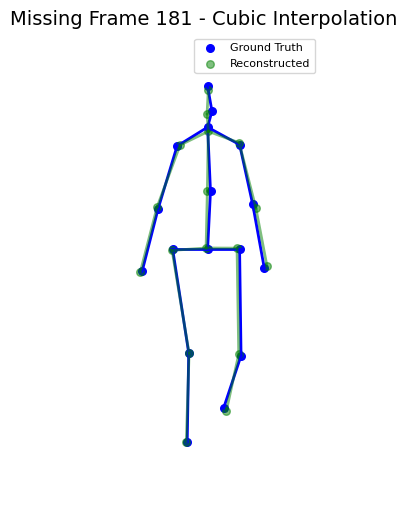

In [55]:
# Choose a missing frame index (e.g., first missing frame)
missing_idxs = np.where(mask == 0)[0]
frame_to_show = missing_idxs[c1]  

gt = keypoints_segment[frame_to_show]        
recon = recon_cubic_all[frame_to_show]           

fig, ax = plt.subplots(figsize=(6, 6))

# Set axis limits with margin
all_x = np.concatenate([gt[:, 0], recon[:, 0]])
all_y = np.concatenate([gt[:, 1], recon[:, 1]])
margin = 50
ax.set_xlim(all_x.min() - margin, all_x.max() + margin)
ax.set_ylim(-(all_y.max() + margin), -(all_y.min() - margin))
ax.set_aspect('equal')
ax.axis('off')

# Ground-truth (blue)
ax.scatter(gt[:, 0], -gt[:, 1], c='blue', s=30, label='Ground Truth')
for i, j in skeleton_edges:
    ax.plot([gt[i, 0], gt[j, 0]], [-gt[i, 1], -gt[j, 1]], 'b-', lw=2)

# Reconstructed (green, transparent)
ax.scatter(recon[:, 0], -recon[:, 1], c='green', s=30, alpha=0.5, label='Reconstructed')
for i, j in skeleton_edges:
    ax.plot([recon[i, 0], recon[j, 0]], [-recon[i, 1], -recon[j, 1]], color='green', lw=2, alpha=0.5)

ax.set_title(f"Missing Frame {frame_to_show} - Cubic Interpolation", fontsize=14)
ax.legend(fontsize=8)
plt.show()


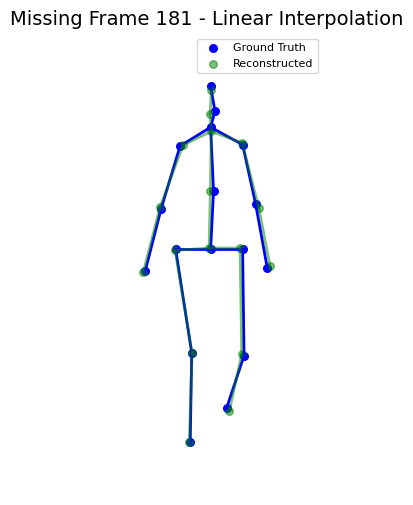

In [55]:
# Choose a missing frame index (e.g., first missing frame)
missing_idxs = np.where(mask == 0)[0]
frame_to_show = missing_idxs[l1]  

gt = keypoints_segment[frame_to_show]        
recon = recon_cubic_all[frame_to_show]           

fig, ax = plt.subplots(figsize=(6, 6))

# Set axis limits with margin
all_x = np.concatenate([gt[:, 0], recon[:, 0]])
all_y = np.concatenate([gt[:, 1], recon[:, 1]])
margin = 50
ax.set_xlim(all_x.min() - margin, all_x.max() + margin)
ax.set_ylim(-(all_y.max() + margin), -(all_y.min() - margin))
ax.set_aspect('equal')
ax.axis('off')

# Ground-truth (blue)
ax.scatter(gt[:, 0], -gt[:, 1], c='blue', s=30, label='Ground Truth')
for i, j in skeleton_edges:
    ax.plot([gt[i, 0], gt[j, 0]], [-gt[i, 1], -gt[j, 1]], 'b-', lw=2)

# Reconstructed (green, transparent)
ax.scatter(recon[:, 0], -recon[:, 1], c='green', s=30, alpha=0.5, label='Reconstructed')
for i, j in skeleton_edges:
    ax.plot([recon[i, 0], recon[j, 0]], [-recon[i, 1], -recon[j, 1]], color='green', lw=2, alpha=0.5)

ax.set_title(f"Missing Frame {frame_to_show} - Linear Interpolation", fontsize=14)
ax.legend(fontsize=8)
plt.show()


Here we find the index where the error is maximum and seems like a good fit for model , if you look for any other Missing frames they almost overlap indicating a very good sign of interpolation!

# Video comparision of both our reconstructed and actual frames!

In [57]:
def draw_side_by_side_skeleton(original_kp, reconstructed_kp, frame_idx=None, title="Side-by-Side Comparison"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for ax, keypoints, label in zip(
        axs, [original_kp, reconstructed_kp], ["Original", "Reconstructed"]
    ):
        x_margin, y_margin = 50, 50
        x_min, x_max = keypoints[:, 0].min(), keypoints[:, 0].max()
        y_min, y_max = keypoints[:, 1].min(), keypoints[:, 1].max()

        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(-(y_max + y_margin), -(y_min - y_margin))
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(label)

        ax.scatter(keypoints[:, 0], -keypoints[:, 1], c='blue', s=20)
        for i, j in skeleton_edges:
            x = [keypoints[i, 0], keypoints[j, 0]]
            y = [-keypoints[i, 1], -keypoints[j, 1]]
            ax.plot(x, y, 'b-', lw=2)

    if frame_idx is not None:
        fig.suptitle(f"{title} - Frame {frame_idx}", fontsize=14)

    fig.tight_layout()
    fig.canvas.draw()
    img = np.asarray(fig.canvas.buffer_rgba())
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    img_bgr = cv2.resize(img_bgr, (800, 400))  # adjust as needed
    plt.close(fig)
    return img_bgr


In [59]:
def write_comparison_video(
    original_kps,
    reconstructed_kps,
    draw_fn,  
    output_path,
    fps=50,
    width=800,
    height=400,
    start_frame=0,
    frame_count=200
):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for f in tqdm(range(start_frame, start_frame + frame_count)):
        orig = original_kps[f]
        recon = reconstructed_kps[f]
        frame_img = draw_fn(orig, recon, f)
        video.write(frame_img)

    video.release()
    print(f"Video saved to: {output_path}")


In [61]:
# Smooth trajectories before comparison (optional but recommended)
smoothed_gt = smooth_trajectory(keypoints_segment)
smoothed_recon = smooth_trajectory(recon_cubic_all)

# Write side-by-side comparison video
write_comparison_video(
    original_kps=smoothed_gt,
    reconstructed_kps=smoothed_recon,
    draw_fn=draw_side_by_side_skeleton,
    output_path="side_by_side_comparison_cubic.mp4",
    fps=50,
    width=800,
    height=400,
    start_frame=0,
    frame_count=segment_len
)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.66it/s]

Video saved to: side_by_side_comparison_cubic.mp4


In [63]:
subprocess.run(['start', 'side_by_side_comparison_cubic.mp4'], shell=True)

CompletedProcess(args=['start', 'side_by_side_comparison_cubic.mp4'], returncode=0)

In [65]:
# Smooth trajectories before comparison (optional but recommended)
smoothed_gt = smooth_trajectory(keypoints_segment)
smoothed_recon = smooth_trajectory(recon_linear_all)

# Write side-by-side comparison video
write_comparison_video(
    original_kps=smoothed_gt,
    reconstructed_kps=smoothed_recon,
    draw_fn=draw_side_by_side_skeleton,
    output_path="side_by_side_comparison_linear.mp4",
    fps=50,
    width=800,
    height=400,
    start_frame=0,
    frame_count=segment_len
)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.64it/s]

Video saved to: side_by_side_comparison_linear.mp4


In [67]:
subprocess.run(['start', 'side_by_side_comparison_linear.mp4'], shell=True)

CompletedProcess(args=['start', 'side_by_side_comparison_linear.mp4'], returncode=0)

# Thank You